# Project 2 
#### William Cropper

### Section 0. References

- [iPython Notebook tutorial](https://www.youtube.com/watch?v=xe_ATRmw0KM)
- [Python Data Analysis Library - Pandas](http://pandas.pydata.org)
- [Calculate variance](http://stackoverflow.com/questions/16670658/python-variance-of-a-list-of-defined-numbers#16670783)
- [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t_test)
- [Shapiro-Wilk test for normality](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
- [Matplotlib gallery](http://matplotlib.org/gallery)
- [Matplotlib Pyplot tutorial](http://matplotlib.org/users/pyplot_tutorial.html)
- [Matplotlib documentation](http://matplotlib.org/contents.html)
- [Plotting documentation](http://pandas.pydata.org/pandas-docs/stable/visualization.html)
- [P-value](https://en.wikipedia.org/wiki/P-value#Misunderstandings)
- [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test)
- [Analyzing and Manipulating Data with Pandas](https://www.youtube.com/watch?v=0CFFTJUZ2dc)
- [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)
- [Difference between One-tailed and Two-tailed tests](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm)

### Section 1. Statistical Test

1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

1.1 ANSWER:
- Statistical test used: Whitney-Mann U test (explanation below)
- One-tail or two-tail: Two-tailed being used because it does not matter if ridership is higher or lower.  Only that it is significantly different.
- Null hypothesis: There is no difference in ridership due to rain.  With H0:P(x > y) = 0.5 and H1:P(x > y) <> 0.5
- P-critical: .05 which reflects a 95% confidence level

1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

In [120]:
# Initial setup

%matplotlib inline
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas import set_option
set_option("display.max_rows", 8)

columns_v2=["UNIT","DATEn","TIMEn","hour","ENTRIESn_hourly","EXITSn_hourly","meanpressurei","fog",
            "rain","meantempi","precipi"]
columns_master=["UNIT","DATEn","TIMEn","Hour","ENTRIESn_hourly","EXITSn_hourly","meanpressurei","fog",
                "rain","meantempi","precipi"]
df = pd.read_csv('improved-dataset/turnstile_weather_v2.csv', usecols=columns_v2)
#df = pd.read_csv('original-dataset/turnstile_data_master_with_weather.csv', usecols=columns_master)

df.rename(columns={'Hour':'hour'}, inplace=True)

In [121]:
# Determine statistical test to use
# Try Shapiro-Wilk

w,p = scipy.stats.shapiro(df['ENTRIESn_hourly'])
print "P-value: %s" % p
print "Sample size: %s" % len(df['ENTRIESn_hourly'])
print "NOTE: The p-value may not be accurate for sample size > 5000"
print "So I will use a plot instead to make a determination"

P-value: 0.0
Sample size: 42649
NOTE: The p-value may not be accurate for sample size > 5000
So I will use a plot instead to make a determination


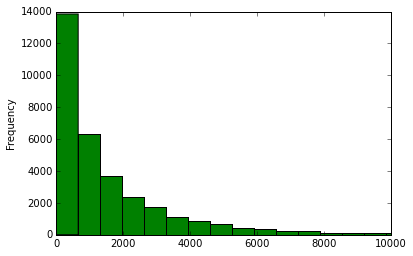


1.2 ANSWER:
Because the two samples are non-parametric (non-normal), the Whitney-Mann U test applies.



In [122]:
rain = df[df.rain==1]['ENTRIESn_hourly']
no_rain = df[df.rain==0]['ENTRIESn_hourly']

rain.plot(kind="hist", bins=50)
no_rain.plot(kind="hist", bins=50)
plt.xlim([0,10000])
plt.show()
print "\n1.2 ANSWER:"
print "Because the two samples are non-parametric (non-normal), the Whitney-Mann U test applies.\n"

1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [123]:
#Mann-Whitney U test

U, p_value = scipy.stats.mannwhitneyu(rain, no_rain)
p_value = p_value * 2

rain_mean = np.mean(rain)
no_rain_mean = np.mean(no_rain)

print "\n1.3 ANSWER:"
print "P-value (two-tail): %s" % p_value
print "Rain mean: %s" % rain_mean
print "No Rain mean: %s" % no_rain_mean


1.3 ANSWER:
P-value (two-tail): 5.48213914249e-06
Rain mean: 2028.19603547
No Rain mean: 1845.53943866


1.4 What is the significance and interpretation of these results?

In [124]:
p_critical = .05

print "\n1.4 ANSWER:"
print "P-critical:", p_critical, "(95% significance level)"
print "P-value:", p_value

if p_value <= p_critical:
    print "The P-value is less than or equal to P-critical.  Therefore, the null hypothesis is rejected."
    print "This implies the ridership is statistically different on rainy days than compared to non-rainy days."    
else:
    print "The P-value is greater than the P-critical.  Therefore, the null hypothesis is accepted."
    print "The samples are consistent with the null hypothesis"
    
print "\nSince the p-value is a positive number, it would indicate that ridership would be higher on rainy days.\n"


1.4 ANSWER:
P-critical: 0.05 (95% significance level)
P-value: 5.48213914249e-06
The P-value is less than or equal to P-critical.  Therefore, the null hypothesis is rejected.
This implies the ridership is statistically different on rainy days than compared to non-rainy days.

Since the p-value is a positive number, it would indicate that ridership would be higher on rainy days.



---
### Section 2. Linear Regression

2.1	What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: (OLS using Statsmodels or Scikit Learn, Gradient descent using Scikit Learn, or something different?)

2.1 ANSWER: OLS using Statsmodels was used to compute theta

In [125]:
# OLS

# define features
features = df[['rain', 'hour', 'meantempi', 'fog']]
dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(dummy_units)

# Values
values = df['ENTRIESn_hourly']

# Perform linear regression
Y = values
X = features
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
params = results.params    
intercept = params[0]
params = params[1:]

predictions = intercept + np.dot(features, params)
print "Predictions:", predictions
print "\ntheta:\n", params[0:4]

#(df['ENTRIESn_hourly'] - predictions).plot(kind='hist')

Predictions: [ -974.11099215  -480.30206426   507.31579151 ...,    52.18012039
   545.98904827  1039.79797616]

theta:
rain         137.051521
hour         123.452232
meantempi    -11.689221
fog         -706.942842
dtype: float64


2.2	What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

In [126]:
print "\n2.2 ANSWER"
print "Features:",features.columns[:4]
print "Dummy:",features.columns[4:]


2.2 ANSWER
Features: Index([u'rain', u'hour', u'meantempi', u'fog'], dtype='object')
Dummy: Index([u'unit_R003', u'unit_R004', u'unit_R005', u'unit_R006', u'unit_R007',
       u'unit_R008', u'unit_R009', u'unit_R011', u'unit_R012', u'unit_R013',
       ...
       u'unit_R373', u'unit_R382', u'unit_R424', u'unit_R429', u'unit_R453',
       u'unit_R454', u'unit_R455', u'unit_R456', u'unit_R459', u'unit_R464'],
      dtype='object', length=240)


2.3	Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model. 

2.3 ANSWER:  The features I selected were based on weather and time.  Rain, fog, or temperature would seem reasonable to expect an impact to ridership.  Along with time of day because of work commuters.

2.4	What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

In [127]:
# define features
features = df[['rain', 'hour', 'meantempi', 'fog']]
#dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
#features = features.join(dummy_units)

# Values
values = df['ENTRIESn_hourly']

# Perform linear regression
Y = values
X = features
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
params = results.params    
intercept = params[0]
params = params[1:]

print "\n2.4 ANSWER:"
print "Parameters w/o dummy:\n", params


2.4 ANSWER:
Parameters w/o dummy:
rain         161.654713
hour         122.431920
meantempi     -8.710963
fog         -706.286112
dtype: float64


2.5	What is your model’s R2 (coefficients of determination) value?

In [128]:
# r-squared
y = values
f = predictions
y_bar=np.mean(y)
r_squared = 1 - ((np.sum((y - f)**2)) / (np.sum((y - y_bar)**2)))

print "\n2.5 ANSWER:"
print "R^2:", r_squared


2.5 ANSWER:
R^2: 0.460688847525


2.6	What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?

2.6 ANSWER:  R2 value represents the ratio between the variance of the predictions with the variance of the data.  The R2 value shows the percentage of what can be explained to what cannot be explained.  The R2 value calculated for the imnproved v2 dataset shows that 46% of the variability is accounted for which would not be a reasonable predictor of ridership based on the features modeled.

---
### Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data. Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

3.1	One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
- You can combine the two histograms in a single plot or you can use two separate plots.
- If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
- For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
- Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.


3.1 ANSWER


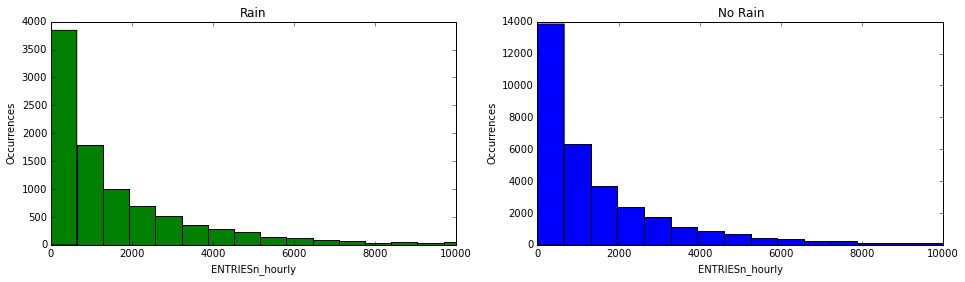

These histograms show the ridership on both rainy and non-rainy days.  Although the histograms look similar,
one cannot assume that there is not a statistical change in ridership.  The histograms do however show that
the samples are non-parametric.



In [129]:
rain = df[df.rain==1]['ENTRIESn_hourly']
no_rain = df[df.rain==0]['ENTRIESn_hourly']

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)
plt.xlim([0,10000])
ax0.hist([rain], bins=50, color='g')
ax0.set_title('Rain')
ax0.set_xlabel('ENTRIESn_hourly')
ax0.set_ylabel('Occurrences')

ax1.hist([no_rain], bins=50, color='b')
ax1.set_title('No Rain')
ax1.set_xlabel('ENTRIESn_hourly')
ax1.set_ylabel('Occurrences')

print "\n3.1 ANSWER"
plt.show()

print "These histograms show the ridership on both rainy and non-rainy days.  Although the histograms look similar,"
print "one cannot assume that there is not a statistical change in ridership.  The histograms do however show that"
print "the samples are non-parametric.\n"

3.2	One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
-Ridership by time-of-day
-Ridership by day-of-week

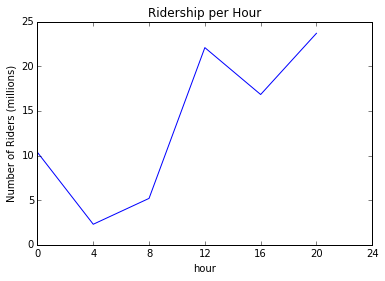

This plot shows the number of riders per hour.  Interestingly the peaks are at noon and at 8pm.
I would have expected highest ridership would be early morning and late afternoon which would
reflect the work commuters.



In [130]:
var=df.groupby(['hour']).ENTRIESn_hourly.sum() / 1000000
plt.xlabel('Hour')
plt.ylabel('Number of Riders (millions)')
var.plot(kind='line', title='Ridership per Hour', xticks=[0,4,8,12,16,20,24]);
plt.show()

print "This plot shows the number of riders per hour.  Interestingly the peaks are at noon and at 8pm."
print "I would have expected highest ridership would be early morning and late afternoon which would"
print "reflect the work commuters.\n"

---
### Section 4. Conclusion
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

4.1	From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

4.1 ANSWER:  Depends on which datasets get analyzed.  The two datsets (original, and improved v2) provided different conclusions.

**Improved v2 (used in this analysis):**
The results from the Mann-Whitney U test provided a p-value of (5.48e-06).  This is much less (by many orders of magnitude) than that of the p-critical value with a significance level of 95%.  This value would indicate that the null hypothesis should be REJECTED.  By rejecting the null hypotheses (no change in ridership when it is raining), leads to the possibility of a change in ridership.  

**Original (used for comparison):**
The results from the Mann-Whitney U test provided a p-value of (0.049999825587).  This is less (or equal if rounding to 2 decinal places) than the p-critical value with a significance level of 95%.  This indicates that the null hypothesis should also be REJECTED.  Which also leads to the possibility of a change in ridership.

4.2	What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

4.2 ANSWER:  First I needed to determine if the data was normal or non-normal before electing a statistical test.  The Shapio Wilk test was not good for datasets larger than 5000, so I plotted the data and determined that the dataset that was to be analyzed was non-normal.  Because the Welch's t-test is for normal datasets, I used the Mann-Whitney U test which is applicable for non-normal datasets.  With regards to Linear Regression, OLS using Statsmodels was used to compute theta.  This provided weights with negative values and causing the predictions to also have some negative values.  Since the R2 was under 50% and having negative predictions, leads me to conclude that the linear regression model should not be used to predict ridership.  Analysis should be soley based on samples and not rely on machine learning.

---
### Section 5. Reflection
Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

5.1	Please discuss potential shortcomings of the methods of your analysis, including:

5.1 ANSWER:
- **Dataset** : As learned from previous feedback, the samples were taken during the month of May, 2011.  It is not clear if this the rainy season in NYC.  Or if 1 month of data is sufficient.  A sample spanning multiple months during different seasons would have been more desirable in determination if rainy weather laffects ridership.
- **Analysis, such as the linear regression model or statistical test** - Again as I stated previously, the linear regression method used (OLS using Statsmodels) did not present good predictions (and weights) based on the value obtained when calculating R2.  If R2 would have been closer to 100% than being under 50% I would have made my conclusion different than stating the method used was inadequate as a predictor.

In [131]:
print "Start date: ", df.DATEn.min()
print "End date: ", df.DATEn.max()

Start date:  05-01-11
End date:  05-31-11


5.2	(Optional) Do you have any other insight about the dataset that you would like to share with us?

5.2 ANSWER: Nothing to contribute. 